In [1]:
from pathlib import Path

import geopandas as gpd
import pandas as pd
import numpy as np
import xarray as xr
from dask.distributed import Client
import matplotlib.pyplot as plt

np.set_printoptions(precision=4, suppress=True)

import ipywidgets as widgets
from IPython.display import display

In [2]:
ds = xr.load_dataset("../data/outputs/plots/metrics/metrics_grid_none_z_1m.nc")

# Site level height profiles

In [3]:
sites = np.unique(ds.site.values)

In [23]:
# This slice is actually > 1m as i represents (i-1, i] m


def plot_site(site):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))


    # Plot 1: inside_pct
    selected = ds.where(ds['site'].isin([site]), drop=True)

        
    z_max = selected['max'].max(dim='plot').item()

    z_slice = slice(2, z_max)

    selected['inside_pct'].sel(z=z_slice).plot.line(y='z', hue='plot', ax=ax1)

    # Add mean line for inside_pct
    mean_inside = selected['inside_pct'].sel(z=z_slice).fillna(0).mean(dim='plot')
    mean_inside.plot.line(y='z', ax=ax1, color='black', linewidth=2, label='Mean', linestyle='--')

    ax1.set_xlabel('Inside Percentage (%)')
    ax1.set_ylabel('Height (m)')
    ax1.set_title(f'Inside Percentage - Site {site}')
    ax1.grid(True, alpha=0.3)
    ax1.set_xlim(0, None)
    ax1.set_ylim(2, None)



    # Plot 2: pad
    selected['pad'].pipe(lambda ds: ds / 0.5).sel(z=z_slice).plot.line(y='z', hue='plot', ax=ax2, alpha=1, linewidth=1)

    # Add mean line for pad
    mean_pad = selected['pad'].pipe(lambda ds: ds / 0.5).sel(z=z_slice).fillna(0).mean(dim='plot')
    mean_pad.plot.line(y='z', ax=ax2, color='black', linewidth=2, label='Mean', linestyle='--')



    ax2.set_xlabel('Plant Area Density (k = 0.5)')
    ax2.set_ylabel('Height (m)')
    ax2.set_title(f'Plant Area Density - Site {site}')
    ax2.grid(True, alpha=0.3)
    ax2.set_xlim(0, None)
    ax2.set_ylim(2, None)

    plt.tight_layout()

sites_dropdown = widgets.Dropdown(
    options=sites,
    value=sites[1],
    description='site:',
    disabled=False,
)

interactive_plot = widgets.interactive(plot_site, site=sites_dropdown)
display(interactive_plot)

interactive(children=(Dropdown(description='site:', index=1, options=(np.str_('AGG_O_01'), np.str_('AGG_O_05')…

# Site type level height profiles

In [5]:
site_types = np.unique(ds.site_type.values)

In [40]:


def plot_site_type(site_type):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

    # Filter data for the selected site type
    selected = ds.where(ds['site_type'].isin([site_type]), drop=True)

    selected['pad'] = selected['pad'].fillna(0)
    selected['inside_pct'] = selected['inside_pct'].fillna(0)

    z_max = selected['max'].max(dim='plot').item()
    z_slice = slice(2, z_max)
    
    # Get unique sites within this site type
    sites_in_type = np.unique(selected.site.values)
    
    # Plot 1: inside_pct
    # Plot a line for each site (which is the mean of plots in that site)
    for site in sites_in_type:
        site_data = selected.where(selected['site'].isin([site]), drop=True)
        site_mean_inside = site_data['inside_pct'].sel(z=z_slice).mean(dim='plot')
        site_mean_inside.plot.line(y='z', ax=ax1, linewidth=2, label=f'Site {site}')
    
    # Add overall mean line for all sites in this site type
    # overall_mean_inside = selected['inside_pct'].sel(z=z_slice).mean(dim='plot')
    # overall_mean_inside.plot.line(y='z', ax=ax1, color='black', linewidth=2, label='Mean of all sites', linestyle='--')

    ax1.set_xlabel('Inside Percentage (%)')
    ax1.set_ylabel('Height (m)')
    ax1.set_title(f'Inside Percentage - Site Type {site_type}')
    ax1.grid(True, alpha=0.3)
    ax1.set_xlim(0, None)
    ax1.set_ylim(2, None)
    # Limit legend entries to avoid clutter
    handles, labels = ax1.get_legend_handles_labels()
    if len(handles) > 10:  # If too many sites, only show mean
        ax1.legend([handles[-1]], [labels[-1]], loc='upper right')
    else:
        ax1.legend(loc='upper right')

    # Plot 2: pad
    # Plot a line for each site (which is the mean of plots in that site)
    for site in sites_in_type:
        site_data = selected.where(selected['site'].isin([site]), drop=True)
        # site_data['pad'].pipe(lambda ds: ds / 0.5).sel(z=z_slice).plot.line(y='z', ax=ax2, linewidth=0.5, alpha=0.3)
        site_mean_pad = site_data['pad'].pipe(lambda ds: ds / 0.5).sel(z=z_slice).mean(dim='plot')
        site_mean_pad.plot.line(y='z', ax=ax2, linewidth=2, label=f'Site {site}')
    
    # Add overall mean line for all sites in this site type
    # overall_mean_pad = selected['pad'].pipe(lambda ds: ds / 0.5).sel(z=z_slice).mean(dim='plot')
    # overall_mean_pad.plot.line(y='z', ax=ax2, color='black', linewidth=2, label='Mean of all sites', linestyle='--')

    ax2.set_xlabel('Plant Area Density (k = 0.5)')
    ax2.set_ylabel('Height (m)')
    ax2.set_title(f'Plant Area Density - Site Type {site_type}')
    ax2.grid(True, alpha=0.3)
    ax2.set_xlim(0, None)
    ax2.set_ylim(2, None)
    # Limit legend entries to avoid clutter
    handles, labels = ax2.get_legend_handles_labels()
    if len(handles) > 10:  # If too many sites, only show mean
        ax2.legend([handles[-1]], [labels[-1]], loc='upper right')
    else:
        ax2.legend(loc='upper right')

    plt.tight_layout()

site_types_dropdown = widgets.Dropdown(
    options=site_types,
    value=site_types[1],
    description='Site Type:',
    disabled=False,
)

interactive_plot_site_type = widgets.interactive(plot_site_type, site_type=site_types_dropdown)
display(interactive_plot_site_type)

interactive(children=(Dropdown(description='Site Type:', index=1, options=(np.str_('AGG'), np.str_('EPO'), np.…

# Plot level profiles with grids

In [24]:
gridded_ds = xr.load_dataset("../data/outputs/plots/metrics/metrics_grid_10m_z_1m.nc")

In [25]:
# Explore the structure of the gridded dataset
# print("Available plots:", gridded_ds.coords['plot'].values[:10], "..." if len(gridded_ds.coords['plot'].values) > 10 else "")
# print("Dataset structure:")
gridded_ds

<xarray.Dataset> Size: 73MB
Dimensions:              (plot: 315, x: 9, y: 9, z: 108)
Coordinates:
  * x                    (x) float64 72B 0.0 10.0 20.0 30.0 ... 60.0 70.0 80.0
  * y                    (y) float64 72B 0.0 10.0 20.0 30.0 ... 60.0 70.0 80.0
  * z                    (z) float64 864B 0.0 1.0 2.0 3.0 ... 105.0 106.0 107.0
  * plot                 (plot) <U12 15kB 'AGG_O_01_P1' ... 'ULY_Y_96_P5'
    site                 (plot) <U9 11kB 'AGG_O_01' 'AGG_O_01' ... 'ULY_Y_96'
    site_type            (plot) <U3 4kB 'AGG' 'AGG' 'AGG' ... 'ULY' 'ULY' 'ULY'
Data variables: (12/39)
    max                  (plot, x, y) float64 204kB nan nan 12.95 ... nan nan
    min                  (plot, x, y) float64 204kB nan nan 0.0 ... nan nan nan
    range                (plot, x, y) float64 204kB nan nan 12.95 ... nan nan
    mean                 (plot, x, y) float64 204kB nan nan 5.278 ... nan nan
    median               (plot, x, y) float64 204kB nan nan 5.205 ... nan nan
    sd                   (plot, x, y) float64 204kB nan nan 3.39 ... nan nan nan
    ...                   ...
    norm_fhd             (plot, x, y) float64 204kB nan nan 0.9056 ... nan nan
    cv_inside_p          (plot, x, y) float64 204kB nan nan 0.6674 ... nan nan
    cv_ppi               (plot, x, y) float64 204kB nan nan 0.4595 ... nan nan
    cv_pad               (plot, x, y) float64 204kB nan nan 2.334 ... nan nan
    x_offset             (plot) float64 3kB 4.63e+05 4.631e+05 ... 4.552e+05
    y_offset             (plot) float64 3kB 5.26e+06 5.26e+06 ... 5.276e+06
Attributes:
    xy_bin_size:  10
    z_bin_size:   1
    weighted:     False

In [26]:
def plot_plot_grid_profiles(plot):

    # This slice is actually > 1m as i represents (i-1, i] m
    z_slice = slice(2, None)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

    # Select the plot data from gridded dataset
    selected_ds = gridded_ds.sel(plot=plot)
    
    # Get the corresponding plot data from non-gridded dataset
    non_gridded_plot = ds.sel(plot=plot)    
    
    # Plot 1: inside_pct for each grid cell
    for x in selected_ds.x.values:
        for y in selected_ds.y.values:
            grid_cell = selected_ds.sel(x=x, y=y)
            if not grid_cell['inside_pct'].sel(z=z_slice).isnull().all():

                grid_cell['inside_pct'].sel(z=z_slice).plot.line(
                    y='z', ax=ax1, alpha=0.3, linewidth=2, color='lightblue'
                )

    # Add mean line for inside_pct across all grid cells
    mean_inside = selected_ds['inside_pct'].sel(z=z_slice).mean(dim=['x', 'y'])
    mean_inside.plot.line(y='z', ax=ax1, color='blue', linewidth=2, label='Grid Mean', linestyle='--')

    # Add non-gridded dataset profile
    non_gridded_plot['inside_pct'].sel(z=z_slice).plot.line(
        y='z', ax=ax1, color='black', linewidth=3, label='Non-gridded Profile'
    )

    ax1.set_xlabel('Inside Percentage (%)')
    ax1.set_ylabel('Height (m)')
    ax1.set_title(f'Inside Percentage - Plot {plot} (Grid Cells + Non-gridded)')
    ax1.grid(True, alpha=0.3)
    ax1.set_xlim(0, None)
    ax1.set_ylim(2, None)
    ax1.legend()

    # Plot 2: pad for each grid cell
    for x in selected_ds.x.values:
        for y in selected_ds.y.values:
            grid_cell = selected_ds.sel(x=x, y=y)
            if not grid_cell['pad'].sel(z=z_slice).isnull().all():
                (grid_cell['pad'].pipe(lambda ds: ds / 0.5).sel(z=z_slice)
                 .plot.line(y='z', ax=ax2, alpha=0.3, linewidth=2, color='lightcoral'))

    # Add mean line for pad across all grid cells
    mean_pad = selected_ds['pad'].pipe(lambda ds: ds / 0.5).sel(z=z_slice).mean(dim=['x', 'y'])
    mean_pad.plot.line(y='z', ax=ax2, color='red', linewidth=2, label='Grid Mean', linestyle='--')

    # Add non-gridded dataset profile
    non_gridded_plot['pad'].pipe(lambda ds: ds / 0.5).sel(z=z_slice).plot.line(
        y='z', ax=ax2, color='black', linewidth=3, label='Non-gridded Profile'
    )

    ax2.set_xlabel('Plant Area Density (k = 0.5)')
    ax2.set_ylabel('Height (m)')
    ax2.set_title(f'Plant Area Density - Plot {plot} (Grid Cells + Non-gridded)')
    ax2.grid(True, alpha=0.3)
    ax2.set_xlim(0, None)
    ax2.set_ylim(2, None)
    ax2.legend()

    plt.tight_layout()

# Get available plots from the gridded dataset
available_plots = gridded_ds.coords['plot'].values

plot_dropdown = widgets.Dropdown(
    options=available_plots,
    value=available_plots[0],
    description='Plot:',
    disabled=False,
)

interactive_plot_grid = widgets.interactive(plot_plot_grid_profiles, plot=plot_dropdown)
display(interactive_plot_grid)

interactive(children=(Dropdown(description='Plot:', options=(np.str_('AGG_O_01_P1'), np.str_('AGG_O_01_P2'), n…

In [128]:
print(gridded_ds[['pad', 'inside_pct']])

<xarray.Dataset> Size: 44MB
Dimensions:     (plot: 315, z: 108, x: 9, y: 9)
Coordinates:
  * x           (x) float64 72B 0.0 10.0 20.0 30.0 40.0 50.0 60.0 70.0 80.0
  * y           (y) float64 72B 0.0 10.0 20.0 30.0 40.0 50.0 60.0 70.0 80.0
  * z           (z) float64 864B 0.0 1.0 2.0 3.0 4.0 ... 104.0 105.0 106.0 107.0
  * plot        (plot) <U12 15kB 'AGG_O_01_P1' 'AGG_O_01_P2' ... 'ULY_Y_96_P5'
    site        (plot) <U9 11kB 'AGG_O_01' 'AGG_O_01' ... 'ULY_Y_96' 'ULY_Y_96'
    site_type   (plot) <U3 4kB 'AGG' 'AGG' 'AGG' 'AGG' ... 'ULY' 'ULY' 'ULY'
Data variables:
    pad         (plot, z, x, y) float64 22MB nan nan 0.0 0.0 ... nan nan nan nan
    inside_pct  (plot, z, x, y) float64 22MB nan nan 0.08929 ... nan nan nan
Attributes:
    xy_bin_size:  10
    z_bin_size:   1
    weighted:     False


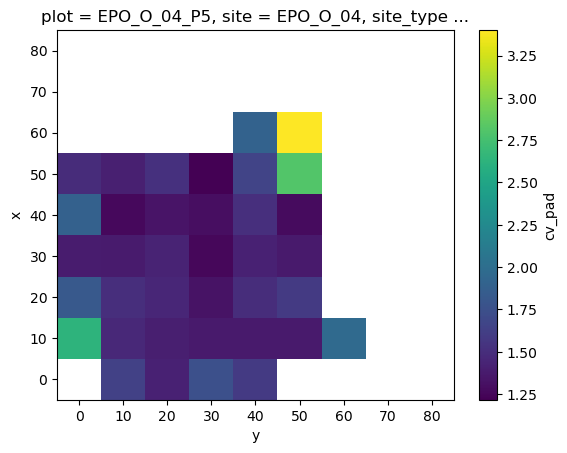

In [129]:
gridded_ds.sel(plot='EPO_O_04_P5')['cv_pad'].plot()


In [130]:
import numpy as np
import xarray as xr
from typing import Literal
from scipy.stats import wasserstein_distance

def _l1_normalize_1d(v: np.ndarray, eps: float = 1e-12) -> np.ndarray:
    """Normalize a 1D profile to sum=1, treating NaNs as 0; return NaNs if empty."""
    v = np.asarray(v, dtype=float)
    v = np.where(np.isnan(v), 0.0, v)
    s = v.sum()
    if s <= eps:
        return np.full_like(v, np.nan)
    return v / s

def _wd(a: np.ndarray, b: np.ndarray, z_vals: np.ndarray) -> float:
    """Wasserstein distance between two 1D profiles on support z_vals; NaN-safe."""
    if np.all(np.isnan(a)) or np.all(np.isnan(b)):
        return np.nan
    a_pdf = _l1_normalize_1d(a)
    b_pdf = _l1_normalize_1d(b)
    if np.any(np.isnan(a_pdf)) or np.any(np.isnan(b_pdf)):
        return np.nan
    return float(wasserstein_distance(z_vals, z_vals, u_weights=a_pdf, v_weights=b_pdf))

def neighbor_wasserstein(
    ds: xr.Dataset,
    var: Literal["pad", "inside_pct"] = "pad",
    neighbors: Literal["4","8"] = "8",
    return_per_cell: bool = False,
) -> xr.DataArray:
    """
    Compute mean Wasserstein distance to neighbors for each cell (then average per plot).
    Returns a DataArray of shape ('plot',) by default (one scalar per plot).
    If return_per_cell=True, returns ('plot','x','y') with each cell's mean neighbor dissimilarity.
    """
    da = ds[var]  # (plot, z, x, y)
    assert list(da.dims) == ["plot", "z", "x", "y"], "Expected dims ('plot','z','x','y')."
    z_vals = da["z"].values
    P, Z, X, Y = da.shape

    # Work in (plot, x, y, z) for easier neighbor indexing
    A = da.transpose("plot", "x", "y", "z").values  # shape (P, X, Y, Z)

    # define neighbor shifts
    shifts = [(1,0), (-1,0), (0,1), (0,-1)]
    if neighbors == "8":
        shifts += [(1,1), (1,-1), (-1,1), (-1,-1)]

    # per-cell accumulators
    # We'll compute per-cell mean of distances across valid neighbor directions.
    per_cell_sum = np.zeros((P, X, Y), dtype=float)
    per_cell_cnt = np.zeros((P, X, Y), dtype=float)

    # Iterate neighbor directions (X,Y are small, so loops are fine and clear)
    for dx, dy in shifts:
        # valid index region (no wrap)
        x_src = slice(max(0, dx), X + min(0, dx))
        y_src = slice(max(0, dy), Y + min(0, dy))
        x_nbr = slice(max(0, -dx), X - max(0, dx))
        y_nbr = slice(max(0, -dy), Y - max(0, dy))

        # compare profiles for all plots & valid cells
        A_src  = A[:, x_src, y_src, :]   # (P, Xv, Yv, Z)
        A_nbr  = A[:, x_nbr, y_nbr, :]   # (P, Xv, Yv, Z)
        Pv, Xv, Yv, _ = A_src.shape

        # compute WD per cell; vectorized over plots but loop over grid for clarity
        # (Z=108 is small; X=Y=9 so this is fast)
        wd_block = np.full((Pv, Xv, Yv), np.nan, dtype=float)
        for p in range(Pv):
            for i in range(Xv):
                for j in range(Yv):
                    wd_block[p, i, j] = _wd(A_src[p, i, j, :], A_nbr[p, i, j, :], z_vals)

        # accumulate
        per_cell_sum[:, x_src, y_src] += wd_block
        per_cell_cnt[:, x_src, y_src] += ~np.isnan(wd_block)

    # per-cell mean across neighbor directions
    with np.errstate(invalid="ignore"):
        per_cell_mean = per_cell_sum / np.where(per_cell_cnt > 0, per_cell_cnt, np.nan)

    if return_per_cell:
        out = xr.DataArray(
            per_cell_mean,
            coords={"plot": ds["plot"].values, "x": ds["x"].values, "y": ds["y"].values},
            dims=("plot","x","y"),
            name=f"{var}_neighbor_wasserstein_{neighbors}",
        )
        out.attrs.update({
            "description": f"Mean Wasserstein distance to {neighbors}-neighbors (L1-normalized profiles)",
            "z_bin_size": ds.attrs.get("z_bin_size", None),
            "xy_bin_size": ds.attrs.get("xy_bin_size", None),
        })
        return out

    # otherwise, reduce to a single scalar per plot
    plot_means = np.nanmean(per_cell_mean, axis=(1,2))  # (plot,)
    out = xr.DataArray(
        plot_means,
        coords={"plot": ds["plot"].values},
        dims=("plot",),
        name=f"{var}_neighbor_wasserstein_{neighbors}",
        attrs={
            "description": f"Plot-level mean Wasserstein distance to {neighbors}-neighbors (L1-normalized profiles)",
            "z_bin_size": ds.attrs.get("z_bin_size", None),
            "xy_bin_size": ds.attrs.get("xy_bin_size", None),
        },
    )
    return out


In [131]:
wd_map = neighbor_wasserstein(gridded_ds, var="pad", neighbors="8", return_per_cell=True)

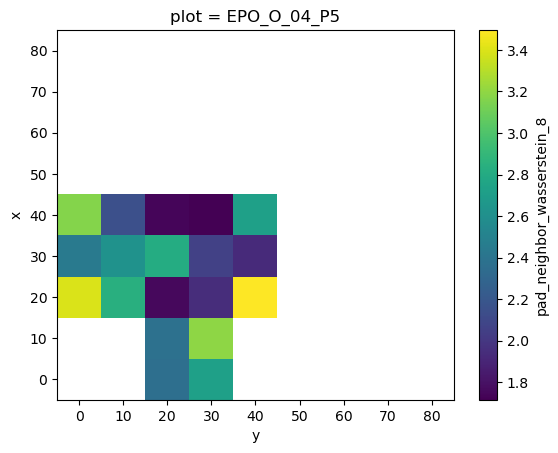

In [132]:
plot = 'EPO_O_04_P5'
wd_map.sel(plot=plot).plot()

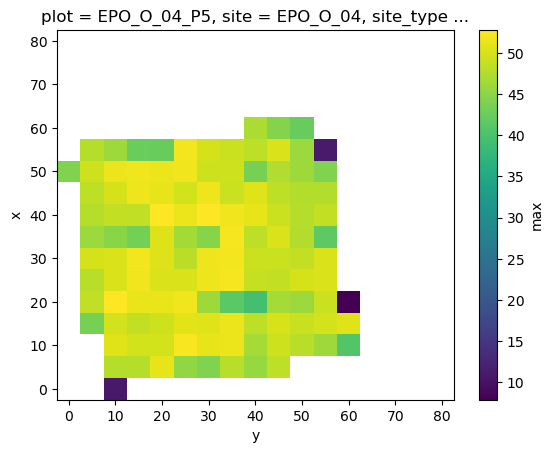

In [117]:
gridded_ds.sel(plot=plot)['max'].plot()

In [120]:
wd_plot = neighbor_wasserstein(gridded_ds, var="pad", neighbors="8", return_per_cell=False)
wd_plot

<xarray.DataArray 'pad_neighbor_wasserstein_8' (plot: 315)> Size: 3kB
array([0.9806, 1.1288, 1.306 , 4.1202, 5.0254, 2.6517, 2.3801, 2.6339,
       2.975 , 3.4841, 4.9971, 0.96  , 0.768 , 1.4778, 5.2716, 0.3079,
       0.2059, 0.3188, 2.0925, 2.0013, 2.1878, 2.7625, 0.8084, 0.4354,
       0.6684, 0.4143, 1.7575, 1.8058, 3.4224, 3.4823, 3.7231, 4.4074,
       3.9614, 3.0554, 3.7453, 2.8618, 3.8071, 3.7006, 0.7253, 0.7298,
       1.8616, 2.6842, 2.6592, 2.8842, 3.0313, 2.0672, 1.8652, 1.8433,
       1.6231, 1.4989, 0.9905, 1.5082, 2.0979, 2.4181, 2.7087, 1.0857,
       1.1546, 1.1765, 1.5352, 1.6983, 2.1985, 2.7162, 2.6255, 2.622 ,
       1.8482, 1.6304, 1.4786, 2.1335, 1.8232, 2.3569, 2.3036, 2.2593,
       2.6412, 2.3962, 3.    , 1.5182, 1.5383, 1.3956, 1.5295, 1.8436,
       0.6119, 0.6709, 0.6386, 0.4737, 0.4378, 0.5035, 0.4496, 0.3626,
       0.3983, 0.3382, 1.6828, 2.43  , 2.6142, 2.2686, 3.0128, 1.6735,
       1.5779, 1.8291, 1.8126, 1.4072, 1.7137, 1.9016, 2.4568, 2.5569,
       3.108 , 1.3237, 1.7076, 1.4295, 1.2779, 1.0944, 1.5484, 1.4186,
       1.393 , 1.5586, 1.2958, 0.9812, 0.9662, 1.1441, 1.273 , 1.059 ,
       3.0071, 2.6117, 3.0146, 2.8866, 2.4656, 1.5309, 1.6382, 1.7847,
       1.4931, 1.4463, 2.3091, 2.5538, 2.7208, 2.7151, 2.9637, 3.3329,
       3.4961, 4.7622, 4.8925, 4.7252, 3.5843, 4.0853, 3.7855, 3.8833,
       3.4647, 1.5716, 1.4465, 2.2769, 1.7376, 1.7004, 0.8829, 0.7296,
       0.7371, 0.6753, 0.9511, 0.638 , 0.7074, 0.8109, 0.7505, 0.912 ,
       0.9677, 0.8798, 0.9375, 0.605 , 0.7569, 0.5142, 0.6318, 0.6628,
       0.6334, 0.8464, 0.4462, 0.6226, 0.5603, 0.4498, 0.6119, 0.1803,
       0.2452, 0.2293, 0.2745, 0.2646, 2.148 , 1.731 , 2.2506, 3.2479,
       2.3285, 2.9887, 2.9158, 2.679 , 2.3989, 2.5734, 1.7491, 1.7967,
       1.9158, 2.068 , 1.7266, 2.106 , 2.2805, 2.6739, 2.9065, 2.8179,
       1.4503, 1.2528, 1.2531, 1.2693, 1.1578, 1.4105, 1.2587, 1.2262,
       1.1758, 1.1761, 1.1299, 1.2323, 1.4335, 1.4809, 1.2701, 0.6711,
       0.6626, 0.7378, 0.6933, 0.726 , 1.4148, 0.9605, 1.0619, 1.0948,
       1.137 , 0.4749, 0.4384, 0.4669, 0.4775, 0.3536, 0.4605, 0.4435,
       0.5892, 0.7103, 0.4859, 0.3262, 0.3264, 0.2769, 0.3208, 0.2918,
       7.6171, 7.3415, 7.7291, 6.3255, 6.189 , 4.1765, 3.1834, 4.1231,
       4.2001, 3.2319, 4.1904, 5.0554, 3.9571, 2.5599, 3.7459, 2.854 ,
       4.3785, 3.9859, 3.6017, 3.3081, 4.6148, 3.9337, 4.7111, 4.3539,
       4.528 , 3.4221, 2.7565, 3.0978, 2.9508, 3.5611, 3.7098, 3.2076,
       3.8237, 3.8844, 4.2923, 3.6689, 3.6529, 3.969 , 4.3866, 3.7955,
       4.061 , 4.2779, 4.1887, 3.9504, 3.4924, 4.7344, 4.487 , 4.2487,
       3.1418, 3.3935, 3.1607, 3.4281, 3.353 , 3.7623, 2.3673, 6.1961,
       3.3247, 4.4249, 2.1641, 1.6199, 2.6938, 3.6406, 4.4815, 5.1729,
       4.2441, 5.1285, 5.5713, 4.9012, 3.8449, 5.0023, 1.7017, 1.6977,
       0.7734, 0.5729, 1.189 ])
Coordinates:
  * plot     (plot) <U12 15kB 'AGG_O_01_P1' 'AGG_O_01_P2' ... 'ULY_Y_96_P5'
Attributes:
    description:  Plot-level mean Wasserstein distance to 8-neighbors (L1-nor...
    z_bin_size:   1
    xy_bin_size:  5

In [123]:
ds['wd'] = wd_plot
ds

<xarray.Dataset> Size: 936kB
Dimensions:              (plot: 315, z: 108)
Coordinates:
  * z                    (z) float64 864B 0.0 1.0 2.0 3.0 ... 105.0 106.0 107.0
  * plot                 (plot) <U12 15kB 'AGG_O_01_P1' ... 'ULY_Y_96_P5'
    site                 (plot) <U9 11kB 'AGG_O_01' 'AGG_O_01' ... 'ULY_Y_96'
    site_type            (plot) <U3 4kB 'AGG' 'AGG' 'AGG' ... 'ULY' 'ULY' 'ULY'
Data variables: (12/38)
    max                  (plot) float64 3kB 16.28 17.18 21.46 ... 19.32 35.28
    min                  (plot) float64 3kB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    range                (plot) float64 3kB 16.28 17.18 21.46 ... 19.32 35.28
    mean                 (plot) float64 3kB 4.428 4.471 5.346 ... 1.36 1.908
    median               (plot) float64 3kB 4.555 4.654 5.666 ... 0.56 0.376
    sd                   (plot) float64 3kB 4.093 4.085 4.651 ... 2.601 4.168
    ...                   ...
    fhd                  (plot) float64 3kB 2.384 2.406 2.556 ... 1.551 1.732
    norm_fhd             (plot) float64 3kB 0.8247 0.8171 ... 0.5093 0.4795
    cv_inside_p          (plot) float64 3kB 1.051 1.099 1.106 ... 2.498 3.2
    cv_ppi               (plot) float64 3kB 0.2682 0.2544 ... 0.2848 0.1992
    cv_pad               (plot) float64 3kB 1.574 1.397 1.646 ... 3.604 4.62
    wd                   (plot) float64 3kB 0.9806 1.129 1.306 ... 0.5729 1.189
Attributes:
    xy_bin_size:  None
    z_bin_size:   1
    weighted:     False

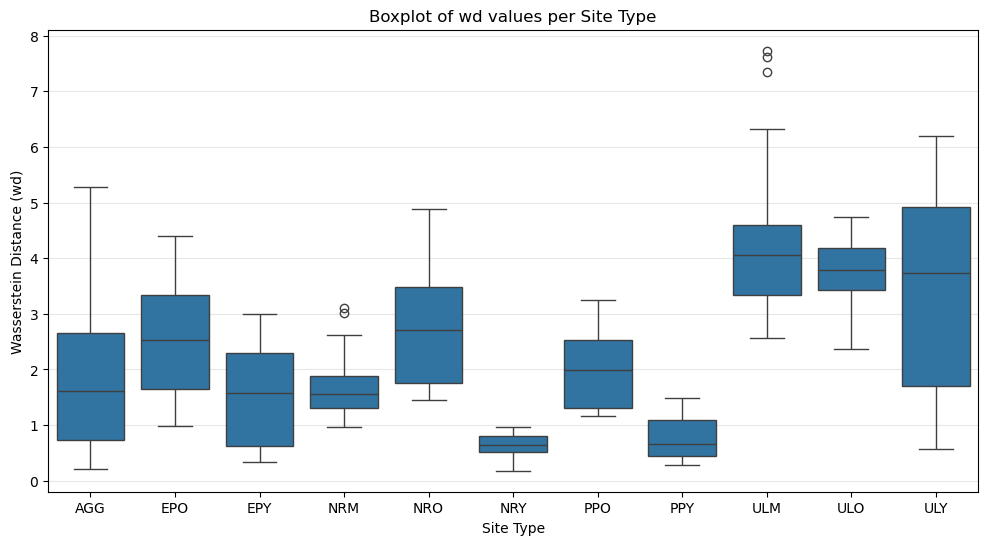

In [124]:
import seaborn as sns

# Prepare data for boxplot
wd_df = pd.DataFrame({
    'wd': wd_plot.values,
    'site_type': ds['site_type'].values
})

plt.figure(figsize=(12, 6))
sns.boxplot(x='site_type', y='wd', data=wd_df)
plt.xlabel('Site Type')
plt.ylabel('Wasserstein Distance (wd)')
plt.title('Boxplot of wd values per Site Type')
plt.grid(True, axis='y', alpha=0.3)
plt.show()